# MGU - PD2

In [46]:
%matplotlib inline
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models
from NetworkAPI import NetworkAPI
import matplotlib.pyplot as plt
import pickle
import json

import seaborn as sns
sns.set_style("whitegrid")
np.random.seed=0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Porównanie wpływu liczby warstw konwolucyjnych na wyniki algorytmu

W poniższej sekcji porównam wpływ liczby warstw konwolucjnych do wyników sieci.  
Zbuduję 3 sieci, składającą się z 3 paczek warstw konwolucyjnych gdzie każda paczka składa się z dwóch warstw konwolucyjnych oraz z warstwy MaxPool. 

Sprawdźmy ile wag ma każda z sieci.

In [27]:
print(f"Sieć duża ma {model_big_params} parametrów")
print(f"Sieć średnia ma {model_medium_params} parametrów")
print(f"Sieć mała ma {model_small_params} parametrów")

Sieć duża ma 1370474 parametrów
Sieć średnia ma 332970 parametrów
Sieć mała ma 275210 parametrów


Po wytrenowaniu sieci stosując metodę wczesnego stopowania po nieosiągnięciu poprawy na zbiorze walidacyjnym przy więcej niż 10 epoków sieci uzyskały następujące wyniki:

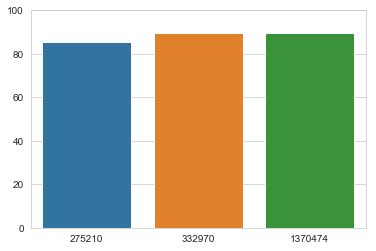

In [50]:
sns.barplot(params, acc)
plt.ylim((0,100))
pass

Jak widać sieć o największej liczbie sekwencji warst konwolucjnych ma najwyższe accuracy, jednak jest ono niewiele większe niż accuracy zbioru drugiego. Możemy zatem wnioskować, że dodawanie kolejnych sekwencji konwolucyjnych nie wiele by dało. Warto natomiast zwrócić uwagę na zbieżność każdej z sieci. Porównajmy zatem wykresy accuracy sieci dużej i średniej.

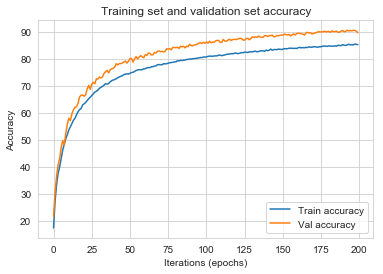

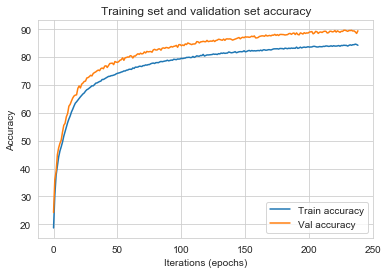

In [57]:
brain_big.plot_accuracy()
brain_medium.plot_accuracy()

Na pierwszym obrazku jest sieć duża, a na drugim średnia. Jak widać sieć duża trochę szybciej zbiega do optymalnego rozwiązania, niż sieć średnia. Może być to związne z tym, że jeśli sieć ma więcej parametrów nie musi ich tak dokładnie optymalizować jak sieć o mniejszej liczbie parametrów.

## Porównanie wpływu liczby filtrów w warstwach konwolucyjnych

W poprzedniej części sprawdzaliśmy jaki wpływ ma dodawanie większej liczby warstw konwolucjnych. W tej zajmiemy się natomiast wielkością każdej warsty czyli liczbą filtrów konwolucyjnych. Poprzednie rozważania możemy nazwać rozszerzaniem sieci wzdłuż, a te rozszerzaniem sieci wszerz.

Podstawową siecią, będzie sieć o dwóch warstw konwolucyjnych, warstwy MaxPool i dwóch warst fully-connected.

In [62]:
with open("brain_small_filter.pkl", "rb") as outfile:
     brain_small = pickle.load(outfile)

In [65]:
with open("brain_medium_filter.pkl", "rb") as outfile:
     brain_medium = pickle.load(outfile)

In [66]:
with open("brain_big_filter.pkl", "rb") as outfile:
     brain_big = pickle.load(outfile)

In [73]:
acc = [brain_small.val_accuracies[-1], brain_medium.val_accuracies[-1], brain_big.val_accuracies[-1]]
conv_size = [8, 64, 256]

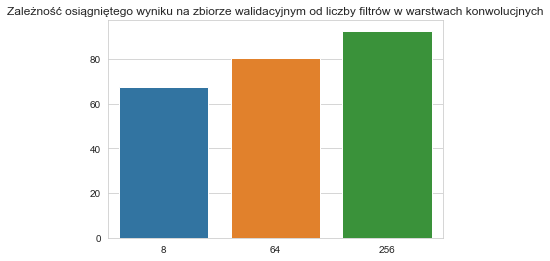

In [76]:
sns.barplot(conv_size, acc)
plt.title("Zależność osiągniętego wyniku na zbiorze walidacyjnym od liczby filtrów w warstwach konwolucjnych")
pass

Jak widać sieć o najmniejszej liczbie filtrów posiada dużo mniejsze zdolności nauczenia się danych niż sieć o dużej liczbie filtrów. Sprawdźmy jak wygląda liczba paramtetrów tych sieci.

In [80]:
big_total_params = sum(p.numel() for p in brain_big.model.parameters() if p.requires_grad)
medium_total_params = sum(p.numel() for p in brain_medium.model.parameters() if p.requires_grad)
small_total_params = sum(p.numel() for p in brain_small.model.parameters() if p.requires_grad)

In [81]:
params = [small_total_params, medium_total_params, big_total_params]

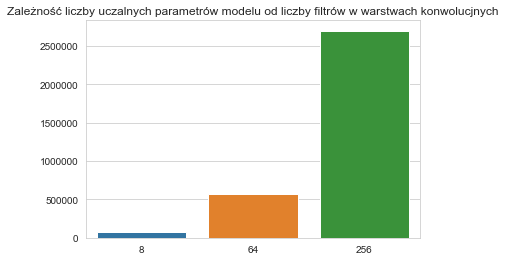

In [83]:
sns.barplot(conv_size, params)
plt.title("Zależność liczby uczalnych parametrów modelu od liczby filtrów w warstwach konwolucjnych")
pass

Jak widać liczba parametrów rośnie wykładniczo w stosunku do liczby filtrów w warstwach konwolucjnych.

Ciekawym wnioskiem z tego eksperymentu jest porównanie tempa rośnięcia accuracy oraz liczby parametrów. Jak widać accuracy rośnie dość liniowo, natomiast liczba parametrów wykładniczo. Jest to jedna z przeszkód z tworzeniem coraz większych sieci. W pewnym momencie zysk na accuracy jest zbyt mały w stosunku do potrzeb obliczeniowych by nauczyć wielkie sieci.

Dodatkowo w przypadku sieci o dużej liczbie parametrów istnieje możliwość przeuczenia modelu, tak by jego wynik na zbiorze testowym był znacząco niższy niż na zbiorze treningowym. By tego uniknąć stosowaliśmy metodę `dropout` i `BatchNorm` o czym więcej w dalszej części raportu.

## Wpływ learnig rate na proces ucznia modelu.

Najważniejszym paramtrem procesu uczenia jest `learning_rate`. Odpowiada on za za szybkość zmiany wag w podstawowym modelu na podstawie gradientu wag. W poniższej sekcji zbadamy jak wybór tego hiperparametru wpływa na proces uczenia. Wybraliśmy sieć podobną do sieci w poprzednim zadaniu i zbadamy jak zachowuję się proces jej uczenia w zależności od wyboru `learning_rate`.

In [90]:
with open("brain_small_lr.pkl", "rb") as f:
    brain_small_lr = pickle.load(f)
with open("brain_medium_lr.pkl", "rb") as f:
    brain_medium_lr = pickle.load(f)
with open("brain_big_lr.pkl", "rb") as f:
    brain_big_lr = pickle.load(f)

Porównajmy krzywę uczenia tych trzech modeli z odpowiednio `learning_rate = 0.01, 0.1 i 1`.

In [106]:
epochs_small = range(1, len(brain_small_lr.val_accuracies) + 1)
epochs_medium = range(1, len(brain_medium_lr.val_accuracies) + 1)
epochs_big = range(1, len(brain_big_lr.val_accuracies) + 1)

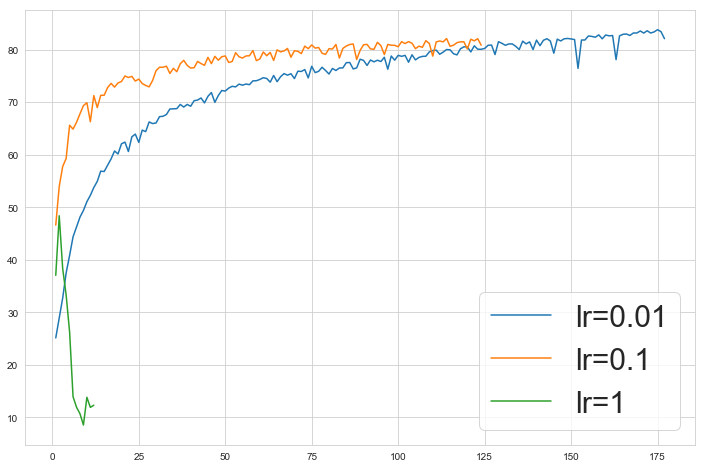

In [118]:
plt.figure(figsize=(12,8))
sns.lineplot(epochs_small, brain_small_lr.val_accuracies, label="lr=0.01")
sns.lineplot(epochs_medium, brain_medium_lr.val_accuracies, label="lr=0.1")
sns.lineplot(epochs_big, brain_big_lr.val_accuracies, label="lr=1")
plt.legend(loc=4, prop={'size': 30})
pass

Jak widać sieć z `learnig_rate=1` nie zbiega i zachowuje się bardzo losowo. Jest to za duża wartość tego parametru i nie prowadzi ona do żadnych sensownych wyników. Natomiast porównując `learning_rate=0.1` z `learning_rate=0.01` możemy dojść do wniosków, że o ile większa wartość tego parametru powoduje szybsze uczenie modelu, to jednak model z mniejszą wartością jest w stanie lepiej nauczyć się danych. Jest to spowodowane najpewniej tym, że w końcowych etapach uczenia, musimy bardzo powoli zmieniać parametry by nie przestrzelić optimum.

Patrząc na powyższy wykres można również dojść do wniosku, że najlepiej kilkanaście pierwszych epoków nauczyć na dość dużym `learning_rate` i potem w miarę osiągania przez sieć coraz lepszych wyników go zmniejszać. Jest to praktyka używana w wielu modelach praktycznych, ponieważ znacznie zmniejsza czas uczenia.

## Test obróbki wstępnej danych wejściowych w zbiorze treningowym.

W bibliotece `pytorch` której używamy do budowy sieci konwolucjnych zostało zaprogramowane wiele różnych opcji zmiany obrazków wejściowych w zbiorze treningowym tak by poprawić wyniki sieci. Ważne by przekształcenia stosować tylko do zbioru treningowego, a nie testowego.

Sprawdźmy jak przekształcenia pomagają zwiększyć accuracy modelu. Będziemy posługiwać się największym modelem testowanym w sekcji porównywania liczby filtrów.

Rozważać będziemy przekształcenie `RandomHorizontalFlop` czyli losowe przewrócenie obrazka w pionie, oraz `noise` czyli dodanie szumu losowego do obrazka.

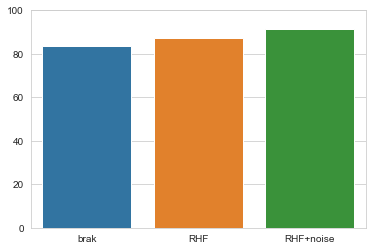

In [122]:
sns.barplot(preprocessing, acc)
plt.ylim((0,100))
pass

Jak widać im więcej preprocessingu tym wynik na zbiorze walidacyjnym jest większy. Prawdopodobnie jest tak ponieważ dodając losowe przekształcenia uodporniamy model na więcej sytuacji w zbiorze testowym, sprawiamy, że lepiej genreralizuje problem, oraz dodajemy mu nowe *sztuczne* obserwacje do zbioru treningowego.